In [1]:
import io
import re
import string

import numpy as np
import jieba
import json
import tqdm

import tensorflow as tf
from tensorflow.keras import layers
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

### 使用今日头条新闻数据集构建W2V数据集

In [2]:
line_num = 0
len_list=[]
with open('train.json') as input_file:
    with open('w2v_corpus.txt','w') as output_file:
        for l in input_file.readlines():
            line_num+=1
            obj = json.loads(l)
            token_list = jieba.lcut(obj['sentence'])
            len_list.append(len(token_list))
            splitted_sentence = " ".join(token_list)
            output_file.write(splitted_sentence+'\n')
max_len = max(len_list)
avg_len = sum(len_list)/line_num
print(f'数据公用{line_num}行，平均词长度{avg_len},最大词长度{max_len}')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.651 seconds.
Prefix dict has been built successfully.


数据公用53360行，平均词长度12.904891304347826,最大词长度81


## 构建Skip-gram数据集构建方法讲解

![cbow & skip gram](https://miro.medium.com/max/700/1*cuOmGT7NevP9oJFJfVpRKA.png)

以`这节课我们一起来学习词嵌入。`为例

In [3]:
sentence = "这节课我们一起来学习词嵌入。"
tokens = jieba.lcut(sentence)
print('分词结果', (tokens))

分词结果 ['这节', '课', '我们', '一', '起来', '学习', '词', '嵌入', '。']


In [4]:
#构建词典
vocab, index = {}, 1  
vocab['<pad>'] = 0  
for token in tokens:
  if token not in vocab:
    vocab[token] = index
    index += 1
vocab_size = len(vocab)
inverse_vocab_dict = {index: token for token, index in vocab.items()}
print('词典',inverse_vocab_dict)

词典 {0: '<pad>', 1: '这节', 2: '课', 3: '我们', 4: '一', 5: '起来', 6: '学习', 7: '词', 8: '嵌入', 9: '。'}


In [5]:
example_sequence = [vocab[word] for word in tokens]
print('句子编码:',example_sequence)

句子编码: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
# 构建正例 ,这里不用skipgram的负例构建
window_size = 2
positive_skip_grams, labels = tf.keras.preprocessing.sequence.skipgrams(
      example_sequence,
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=0)
for target, context in positive_skip_grams[:]:
  print(f"({target}, {context}): ({inverse_vocab_dict[target]}, {inverse_vocab_dict[context]})")

(5, 4): (起来, 一)
(8, 6): (嵌入, 学习)
(2, 4): (课, 一)
(4, 2): (一, 课)
(4, 3): (一, 我们)
(4, 6): (一, 学习)
(4, 5): (一, 起来)
(3, 1): (我们, 这节)
(3, 5): (我们, 起来)
(1, 2): (这节, 课)
(2, 1): (课, 这节)
(6, 4): (学习, 一)
(8, 7): (嵌入, 词)
(7, 9): (词, 。)
(3, 2): (我们, 课)
(5, 3): (起来, 我们)
(7, 5): (词, 起来)
(7, 8): (词, 嵌入)
(5, 7): (起来, 词)
(6, 8): (学习, 嵌入)
(7, 6): (词, 学习)
(9, 8): (。, 嵌入)
(6, 5): (学习, 起来)
(2, 3): (课, 我们)
(9, 7): (。, 词)
(6, 7): (学习, 词)
(5, 6): (起来, 学习)
(8, 9): (嵌入, 。)
(3, 4): (我们, 一)
(1, 3): (这节, 我们)


In [7]:
# 随机为target词选取n个负例，还可以考虑将正例从随机选择的负例中剔除
target_word, context_word = positive_skip_grams[0]

num_ns = 4  # 负例数量

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  
    num_true=1,  
    num_sampled=num_ns,  
    unique=True, 
    range_max=vocab_size,  
    seed=SEED,  
    name="negative_sampling"  
)
print(negative_sampling_candidates)
print([inverse_vocab_dict[index.numpy()] for index in negative_sampling_candidates])

tf.Tensor([1 6 3 8], shape=(4,), dtype=int64)
['这节', '学习', '我们', '嵌入']


In [8]:
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

context = tf.concat([context_class, negative_sampling_candidates], 0)

label = tf.constant([1] + [0]*num_ns, dtype="int64")

target = tf.squeeze(target_word)
context = tf.squeeze(context)
label = tf.squeeze(label)

print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab_dict[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab_dict[c.numpy()] for c in context]}")
print(f"label           : {label}")

target_index    : 5
target_word     : 起来
context_indices : [4 1 6 3 8]
context_words   : ['一', '这节', '学习', '我们', '嵌入']
label           : [1 0 0 0 0]


##  构建数据集

这里构建数据集的方式和前面方法一致,只是使用了一些keras API来降低开发复杂度

In [9]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    targets, contexts, labels = [], [], []

    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size) #构建采样概率表,用来平衡对不同数据的采样操作

    for sequence in tqdm.tqdm(sequences):
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0)

        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
                tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=SEED,
                name="negative_sampling")

            negative_sampling_candidates = tf.expand_dims(
                negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0] * num_ns, dtype="int64")

            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [10]:
def custom_standardization(input_data):  
    """对数据进行标准化(去除标点符号)"""
    return tf.strings.regex_replace(input_data,
                                  '[%s]' % re.escape(string.punctuation+'，。？！、：“”()（）《》'), '')

vocab_size = 8000
sequence_length = 20

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [11]:
text_ds = tf.data.TextLineDataset('w2v_corpus.txt')

In [12]:
vectorize_layer.adapt(text_ds.batch(1024))

In [13]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:100])

['', '[UNK]', '的', '了', '是', '你', '有', '在', '吗', '什么', '中国', '为什么', '如何', '都', '和', '怎么', '人', '不', '被', '会', '我', '对', '美国', '年', '看', '上', '—', '最', '能', '这', '一个', '好', '要', '还', '就', '将', '后', '大', '与', '中', '让', '哪些', '5', '他', '世界', '去', '却', '到', '谁', '新', '月', '2018', '多', '可以', '说', '也', '又', '上联', '个', '来', '下联', '网友', '如果', '手机', '做', '万', '日本', '还是', '用', '没有', '现在', '为', '农村', '…', '买', '为何', '」', '「', '这个', '给', '3', '把', '呢', '岁', '怎样', '10', '多少', '一', '｜', '很', '哪个', '国家', '知道', '到底', '更', '她', '4', '真的', '俄罗斯', '想']


In [14]:
text_vector_ds = text_ds.batch(1024).prefetch(tf.data.AUTOTUNE).map(vectorize_layer).unbatch()

In [15]:
sequences = list(text_vector_ds.as_numpy_iterator())
print('训练数据总条数：',len(sequences))

训练数据总条数： 53360


In [16]:
# 原句和onehot embedding样例
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[1307  199   63 1302  985  224 1249   81   63 1039    3  331  237 1082
   40  224  962  177   15  112] => ['上课时', '学生', '手机', '响个', '不停', '老师', '一怒之下', '把', '手机', '摔', '了', '家长', '拿', '发票', '让', '老师', '赔', '大家', '怎么', '看待']
[   1 4442  571 1036  436 7890 2971    1   21  123  325   23    1    2
    1    1    1    1    2  929] => ['[UNK]', '环球', '股份', '有限公司', '关于', '延期', '回复', '[UNK]', '对', '公司', '2017', '年', '[UNK]', '的', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '的', '公告']
[ 716 3212  123   74    3 2151 2160   13 4597    3   70 6774  984  230
    3   15 1243    0    0    0] => ['通过', '中介', '公司', '买', '了', '二手房', '首付', '都', '付', '了', '现在', '卖家', '不想', '卖', '了', '怎么', '处理', '', '', '']
[ 51  23  45  98  24 721   1  86 110   0   0   0   0   0   0   0   0   0
   0   0] => ['2018', '年', '去', '俄罗斯', '看', '世界杯', '[UNK]', '多少', '钱', '', '', '', '', '', '', '', '', '', '', '']
[   1    2 4154    1    1 2194 3173  341 2233 1547    0    0    0    0
    0    0    0    0    0    0] => ['[UNK]', '的', '个性'

In [17]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53360/53360 [00:44<00:00, 1198.41it/s]




targets.shape: (382689,)
contexts.shape: (382689, 5)
labels.shape: (382689, 5)


In [18]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


## 模型构建
 1. embedding层（onehot->tensor）+ 矩阵相乘 = 相似度
 2. 这里对target和context使用了不同的嵌入层, 不过模型结构可以调整

In [19]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embedding_dim = embedding_dim
        self.target_embedding = layers.Embedding(vocab_size,
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
                                           embedding_dim,
                                           input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)  # 可以理解成向量元素相乘再求和
        return dots

In [20]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [22]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
373/373 [==============================] - 9s 22ms/step - loss: 1.5094 - accuracy: 0.3762
Epoch 2/20
373/373 [==============================] - 8s 21ms/step - loss: 1.3646 - accuracy: 0.4605
Epoch 3/20
373/373 [==============================] - 8s 21ms/step - loss: 1.2765 - accuracy: 0.5114
Epoch 4/20
373/373 [==============================] - 8s 22ms/step - loss: 1.1714 - accuracy: 0.5744
Epoch 5/20
373/373 [==============================] - 8s 22ms/step - loss: 1.0600 - accuracy: 0.6366
Epoch 6/20
373/373 [==============================] - 8s 22ms/step - loss: 0.9512 - accuracy: 0.6906
Epoch 7/20
373/373 [==============================] - 8s 22ms/step - loss: 0.8494 - accuracy: 0.7363
Epoch 8/20
373/373 [==============================] - 8s 21ms/step - loss: 0.7569 - accuracy: 0.7744
Epoch 9/20
373/373 [==============================] - 8s 21ms/step - loss: 0.6744 - accuracy: 0.8071
Epoch 10/20
373/373 [==============================] - 8s 22ms/step - loss: 0.6016 - accura

### tensorboard输出

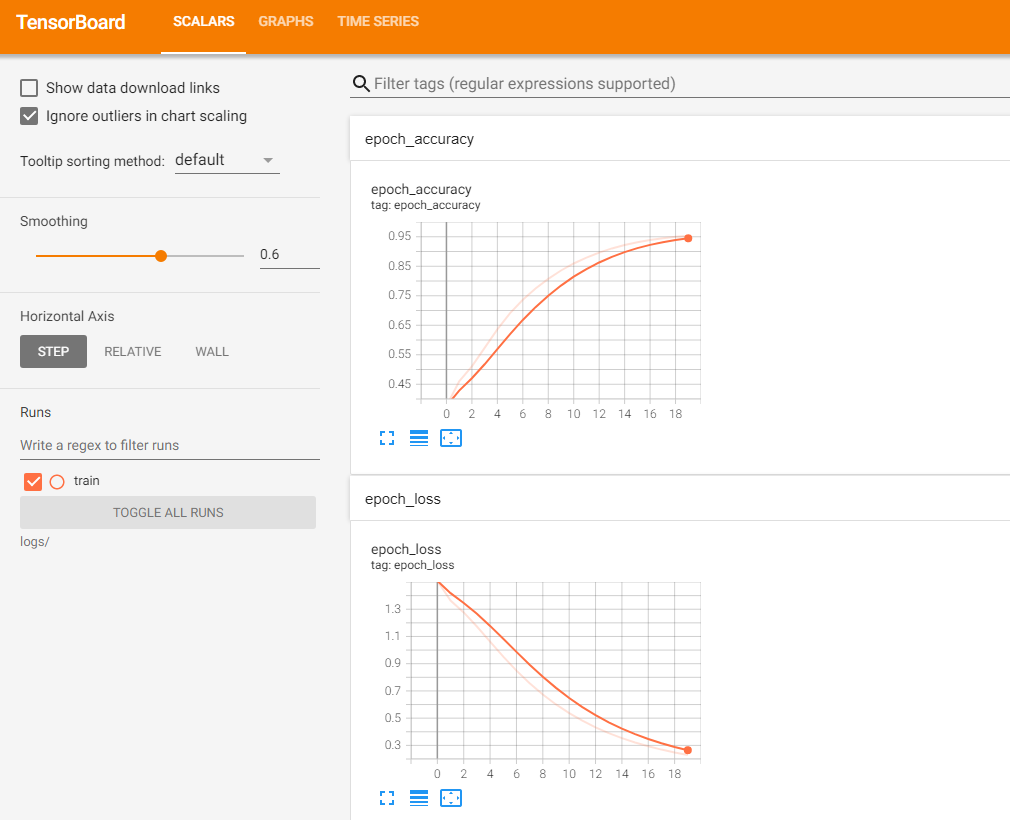

## W2V的embedding获取

In [23]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()
index_vocab = {v:i for i,v in enumerate(vocab)}

### 举例

In [24]:
# candidate_list = ['中国','美国','日本','英国', '法国','德国'，'越南'] ['大国'，'发达']


def calculate_dis(word1,word2):
    if (word1 not in index_vocab or word2 not in index_vocab):
        raise Exception(f'{word1} 或 {word2} 不在词表中')
    vec1 = weights[index_vocab[word1]]
    vec2 = weights[index_vocab[word2]]
    return np.sum(np.square(vec1-vec2))
    
count = 0
for word1 in ['大国','富裕']:
    if count>10:
        break
    for word2 in ['中国','美国','日本','英国','法国','德国','越南']:
        distance = calculate_dis(word1,word2)
        if distance!=0 :
            print(f'[{word1}]和[{word2}]的距离是 {distance}')
            count+=1


[大国]和[中国]的距离是 16.831966400146484
[大国]和[美国]的距离是 20.225608825683594
[大国]和[日本]的距离是 19.882492065429688
[大国]和[英国]的距离是 17.923961639404297
[大国]和[法国]的距离是 22.192155838012695
[大国]和[德国]的距离是 16.45687484741211
[大国]和[越南]的距离是 19.950305938720703
[富裕]和[中国]的距离是 17.12238883972168
[富裕]和[美国]的距离是 17.621747970581055
[富裕]和[日本]的距离是 15.964193344116211
[富裕]和[英国]的距离是 21.92197036743164
[富裕]和[法国]的距离是 20.73276138305664
[富裕]和[德国]的距离是 15.814231872558594
[富裕]和[越南]的距离是 16.285099029541016


In [25]:
candidate_list = vocab[2:]
count = 0
for word1 in candidate_list:
    if count>20:
        break
    for word2 in candidate_list:
        distance = calculate_dis(word1,word2)
        if distance!=0 and distance<9:
            print(f'[{word1}]和[{word2}]的距离是 {distance}')
            count+=1

[说]和[烟]的距离是 8.911432266235352
[下联]和[下句]的距离是 6.558091163635254
[下联]和[飘香]的距离是 7.7965545654296875
[下联]和[对句]的距离是 8.742475509643555
[下联]和[克制]的距离是 8.891918182373047
[下联]和[五州亲]的距离是 8.743525505065918
[下联]和[浅]的距离是 8.519316673278809
[知道]和[认识]的距离是 8.21878433227539
[知道]和[可惜]的距离是 8.971099853515625
[知道]和[银行卡]的距离是 8.620810508728027
[知道]和[眼中]的距离是 8.513176918029785
[知道]和[道理]的距离是 7.5686235427856445
[知道]和[小国]的距离是 8.45608901977539
[知道]和[表达]的距离是 8.3201904296875
[知道]和[这辈子]的距离是 8.663381576538086
[知道]和[学到]的距离是 8.828834533691406
[知道]和[吃亏]的距离是 8.401939392089844
[知道]和[没什么]的距离是 7.8997368812561035
[知道]和[看不懂]的距离是 8.569522857666016
[知道]和[飘]的距离是 8.689916610717773
[知道]和[秘密武器]的距离是 8.808694839477539
[知道]和[混凝土]的距离是 8.936899185180664
